https://blog.keras.io/building-autoencoders-in-keras.html

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop
from keras import layers
import tensorflow as tf
import tensorflow_probability as tfp
from keras import ops

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load Dataset
train_df = pd.read_csv("/content/drive/MyDrive/24-25 Academic Year/CS156/Second Pipeline/0. Dataset/augmented_data.csv")
test_df = pd.read_csv("/content/drive/MyDrive/24-25 Academic Year/CS156/Second Pipeline/0. Dataset/test_data.csv")
val_df = pd.read_csv("/content/drive/MyDrive/24-25 Academic Year/CS156/Second Pipeline/0. Dataset/val_data.csv")

In [5]:
X_train = train_df.drop(columns=['label'])
y_train = train_df['label']
X_test = test_df.drop(columns=['label'])
y_test = test_df['label']
X_val = val_df.drop(columns=['label'])
y_val = val_df['label']

In [6]:
X_train

,pixel0_0,pixel0_1,pixel0_2,pixel0_3,pixel0_4,pixel0_5,pixel0_6,pixel0_7,pixel0_8,pixel0_9,...,pixel63_54,pixel63_55,pixel63_56,pixel63_57,pixel63_58,pixel63_59,pixel63_60,pixel63_61,pixel63_62,pixel63_63
0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9235,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
9236,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
9237,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
9238,0.0,0.0,0.062745,0.0,0.050980,0.000000,0.0,0.070588,0.0,0.039216,...,0.066667,0.007843,0.000000,0.0,0.019608,0.043137,0.070588,0.000000,0.0,0.086275


In [7]:
X_train.shape

(9240, 4096)

In [26]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, backend as K

# Model dimensions
original_dim = 64 * 64  # 4096 pixels
intermediate_dim = 64
latent_dim = 10

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_sigma = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(z_log_sigma * 0.5) * epsilon

class VAE(keras.Model):
    def __init__(self, original_dim, intermediate_dim, latent_dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.original_dim = original_dim
        self.total_loss_tracker = keras.metrics.Mean(name='loss')
        self.reconstruction_loss_tracker = keras.metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = keras.metrics.Mean(name='kl_loss')

        # Build encoder
        encoder_inputs = keras.Input(shape=(original_dim,))
        x = layers.Dense(intermediate_dim, activation='relu')(encoder_inputs)
        self.z_mean = layers.Dense(latent_dim)(x)
        self.z_log_var = layers.Dense(latent_dim)(x)
        z = Sampling()([self.z_mean, self.z_log_var])
        self.encoder = keras.Model(encoder_inputs, [self.z_mean, self.z_log_var, z])

        # Build decoder
        decoder_inputs = keras.Input(shape=(latent_dim,))
        x = layers.Dense(intermediate_dim, activation='relu')(decoder_inputs)
        decoder_outputs = layers.Dense(original_dim, activation='sigmoid')(x)
        self.decoder = keras.Model(decoder_inputs, decoder_outputs)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            # Encode and decode
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)

            # Reconstruction loss (pixel-wise binary crossentropy)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(y, reconstruction)
            ) * self.original_dim

            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )

            # Total loss
            total_loss = reconstruction_loss + kl_loss

        # Get gradients and update weights
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

# Define a dummy loss function
def dummy_loss(y_true, y_pred):
    return tf.zeros_like(y_true[:,0])

# Create and compile the model
vae = VAE(original_dim, intermediate_dim, latent_dim)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=dummy_loss)

# Train the model
history = vae.fit(
    X_train,
    X_train,
    epochs=100,
    batch_size=128,
    validation_data=(X_val, X_val),
    verbose=1
)

Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 74s 47ms/step - kl_loss: 19.1212 - loss: 1963.3275 - reconstruction_loss: 1944.2063 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - kl_loss: 18.3623 - loss: 1156.7006 - reconstruction_loss: 1138.3381 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - kl_loss: 17.2264 - loss: 1003.4662 - reconstruction_loss: 986.2396 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - kl_loss: 16.9174 - loss: 926.4791 - reconstruction_loss: 909.5616 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - kl_loss: 15.8263 - loss: 888.5349 - reconstruction_loss: 872.7084 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+

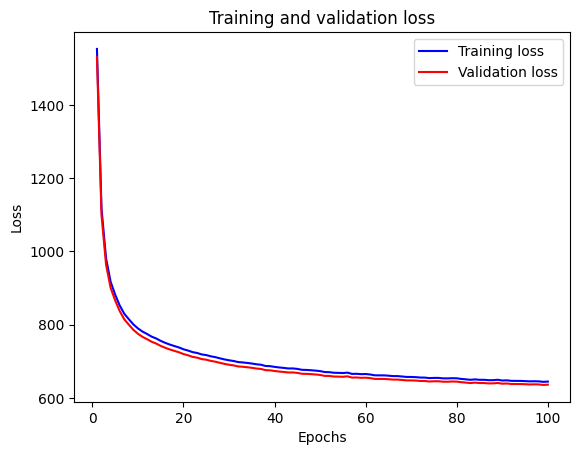

In [27]:
train_loss = history.history['loss']
val_loss = history.history['reconstruction_loss']

# Plot the loss
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


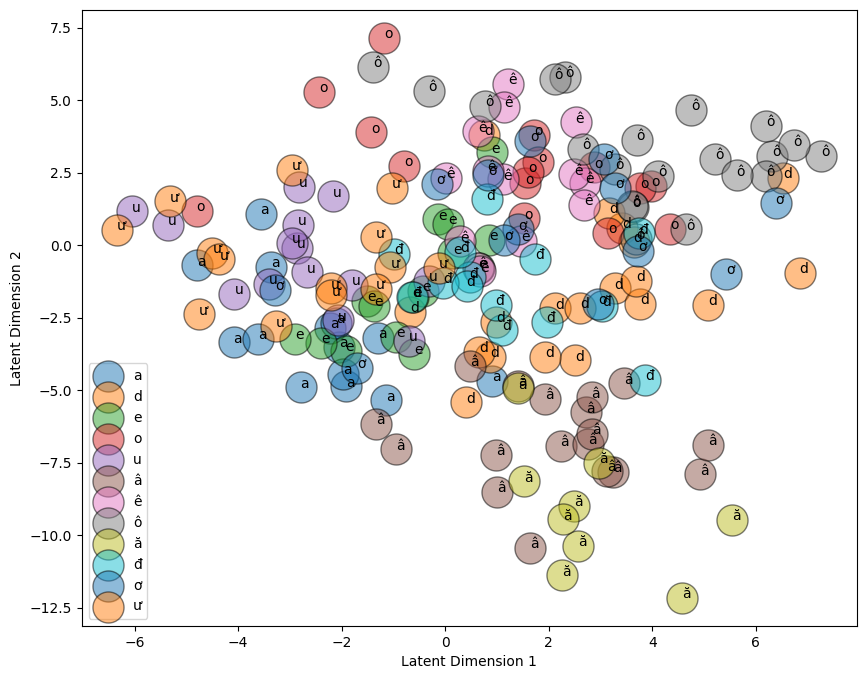

In [44]:
x_test_encoded = vae.encoder.predict(X_test, batch_size=256)
latent_representation = x_test_encoded[2]

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

# Get unique labels and their corresponding encoded values
unique_labels = np.unique(y_test)
encoded_labels = label_encoder.transform(unique_labels)

# Plot the scatter plot
plt.figure(figsize=(10, 8))  # Adjust figure size as needed

# Plot each letter separately to annotate
for label, encoded_label in zip(unique_labels, encoded_labels):
    indices = np.where(y_test_encoded == encoded_label)
    plt.scatter(latent_representation[indices, 0],
                latent_representation[indices, 1],
                label=label,
                s=500,
                alpha=0.5,
                edgecolor='black')

# Add labels to points
for i, txt in enumerate(y_test):
    plt.annotate(txt, (latent_representation[i, 0], latent_representation[i, 1]))

plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.legend()
plt.show()

In [33]:
latent_dim

10

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

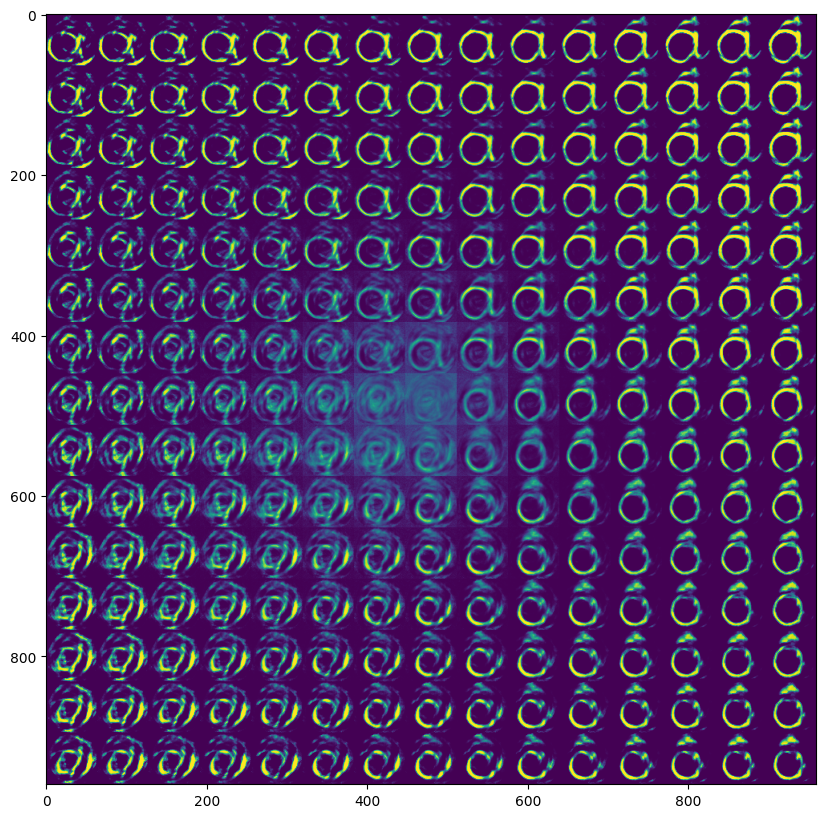

In [45]:
# Display a 2D manifold of the digits
n = 15
letter_size = 64
figure = np.zeros((letter_size * n, letter_size * n))

grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.zeros((1, latent_dim))
        z_sample[0, :2] = [xi, yi]

        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(letter_size, letter_size)
        figure[i * letter_size: (i + 1) * letter_size,
               j * letter_size: (j + 1) * letter_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()